<a href="https://colab.research.google.com/github/slowvak/MC4-TensorflowUNet/blob/master/Basic_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf ./MC4-TensorflowUNet

!rm -rf trainimages
!mkdir trainimages
!rm -rf trainmasks
!mkdir trainmasks

!rm -rf validationimages
!mkdir validationimages
!rm -rf validationmasks
!mkdir validationmasks

!rm -rf testimages
!mkdir testimages
!rm -rf testmasks
!mkdir testmasks

!git clone https://github.com/slowvak/MC4-TensorflowUNet.git

!unzip -q -o "./MC4-TensorflowUNet/Pt1-001-018.zip"
!unzip -q -o "./MC4-TensorflowUNet/Pt2-019-033.zip"
!unzip -q -o "./MC4-TensorflowUNet/Pt5-064-082.zip"
!mv *-Mask.jpg ./trainmasks
!mv *.jpg ./trainimages

!unzip -q -o "./MC4-TensorflowUNet/Pt3-034-047.zip"
!mv *-Mask.jpg ./validationmasks
!mv *.jpg ./validationimages

!unzip -q -o "./MC4-TensorflowUNet/Pt4--048-063.zip"
!mv *-Mask.jpg ./testmasks
!mv *.jpg ./testimages

Cloning into 'MC4-TensorflowUNet'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 112 (delta 9), reused 0 (delta 0), pack-reused 85
Receiving objects: 100% (112/112), 371.49 MiB | 34.35 MiB/s, done.
Resolving deltas: 100% (11/11), done.
Checking out files: 100% (93/93), done.


In [2]:
!pip install -q keras
!pip install natsort
import numpy as np
import os
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Dense, Dropout, Activation, Flatten, BatchNormalization, Reshape
from keras.layers.merge import concatenate, add
from keras.layers.core import Lambda
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import imageio
from natsort import natsorted

Using TensorFlow backend.


In [3]:
train_X = []
train_Y = []
val_X = []
val_Y = []
test_X = []
test_Y = []


trainlimit = 3000  # no limit
validlimit = 400
testlimit = 100  # will also load some test images for the end

im_list = natsorted(os.listdir('./trainimages'))
for f in im_list:
  pth = './trainimages/' + f 
  img = imageio.imread(pth)
  if len(train_X) < trainlimit:
    train_X.append(np.array(img))
train_X = np.array(train_X)
train_X = train_X/255
train_X = train_X[..., np.newaxis]

im_list = natsorted(os.listdir('./trainmasks'))
for f in im_list:
  pth = './trainmasks/' + f 
  img = imageio.imread(pth)
  if len(train_Y) < trainlimit:
    train_Y.append(np.array(img))
train_Y = np.array(train_Y)
train_Y = (train_Y > 100).astype(np.float32)
train_Y = train_Y[..., np.newaxis]

im_list = natsorted(os.listdir('./validationimages'))
for f in im_list:
  pth = './validationimages/' + f 
  img = imageio.imread(pth)
  if len(val_X) < validlimit:
    val_X.append(np.array(img))
val_X = np.array(val_X)
val_X = val_X/255
val_X = val_X[..., np.newaxis]

im_list = natsorted(os.listdir('./validationmasks'))
for f in im_list:
  pth = './validationmasks/' + f 
  img = imageio.imread(pth)
  if len(val_Y) < validlimit:
    val_Y.append(np.array(img))
val_Y = np.array(val_Y)
val_Y = (val_Y > 100).astype(np.float32)
val_Y = val_Y[..., np.newaxis]

im_list = natsorted(os.listdir('./testimages'))
for f in im_list:
  pth = './testimages/' + f 
  img = imageio.imread(pth)
  if len(test_X) < testlimit:
    test_X.append(np.array(img))
test_X = np.array(test_X)
test_X = test_X/255
test_X = test_X[..., np.newaxis]

im_list = natsorted(os.listdir('./testmasks'))
for f in im_list:
  pth = './testmasks/' + f 
  img = imageio.imread(pth)
  if len(test_Y) < testlimit:
    test_Y.append(np.array(img))
test_Y = np.array(test_Y)
test_Y = (test_Y > 100).astype(np.float32)
test_Y = test_Y[..., np.newaxis]

print(train_X.shape[0],"images for training,", val_X.shape[0], "images for validation, and", test_X.shape[0], "images for testing")


3000 images for training, 400 images for validation, and 100 images for testing


In [0]:
#wImg = np.ones(train_Y.shape)
#index = np.where(train_Y == 1)
#wImg[index] = 10000
#wImg = wImg[...,0]

In [0]:
# Cell 

def dice_coeff(y_true, y_pred):
    smooth = 0.000001
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    if y_true_f + y_pred_f == 0:
        return 4 * smooth
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

#binary cross entropy is another function that can perform well
def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [6]:
def build_model(act_fn = 'relu', init_fn = 'he_normal'):

    inputs = Input((256,256,1))

    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
#    conv10 = Reshape((65536, 1))(conv10)

    model = Model(inputs = inputs, outputs = conv10)
    model.summary()

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics=[dice_coeff])
    
    return model
  
model = build_model(act_fn = 'relu', init_fn = 'he_normal')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 256, 256, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_15[0][0]                  
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 128, 128, 128 73856       max_pooling2d_5[0][0]            
__________________________________________________________________________________________________
max_poolin

In [8]:
#!rm -rf ./log
#!mkdir ./log
#LOG_DIR = './log'
#from keras.callbacks import TensorBoard
#tbCallBack = TensorBoard(log_dir='./log')

checkpointer = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

epochs = 5
batch_size = 26
results = model.fit(train_X, train_Y, validation_data=(val_X, val_Y), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])



Train on 3000 samples, validate on 400 samples
Epoch 1/5
 754/3000 [======>.......................] - ETA: 4:24 - loss: 0.0639 - dice_coeff: 0.1011

KeyboardInterrupt: ignored

100/100 [==============================] - 3s 32ms/step


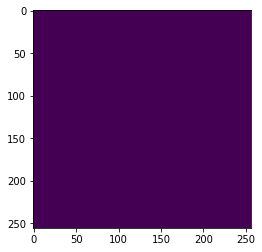

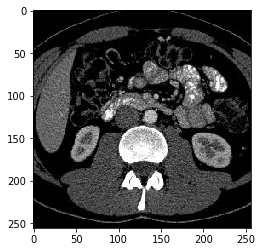

<Figure size 432x288 with 0 Axes>

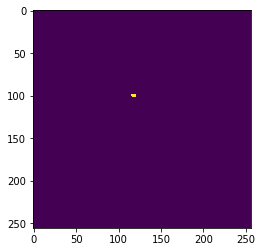

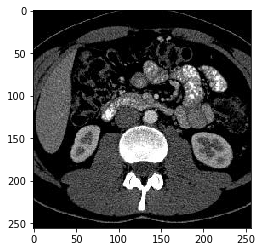

<Figure size 432x288 with 0 Axes>

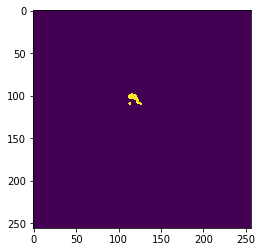

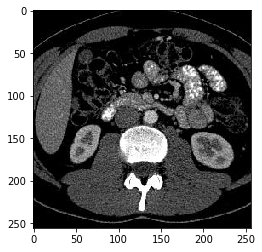

<Figure size 432x288 with 0 Axes>

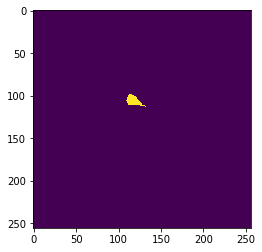

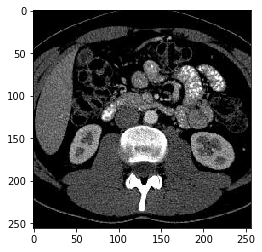

<Figure size 432x288 with 0 Axes>

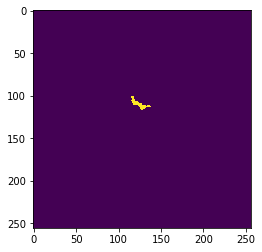

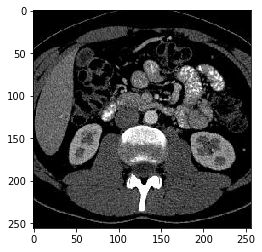

<Figure size 432x288 with 0 Axes>

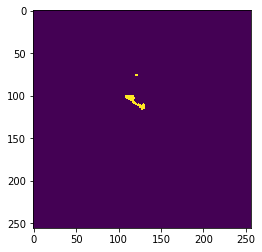

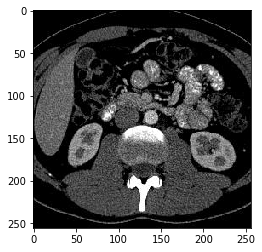

<Figure size 432x288 with 0 Axes>

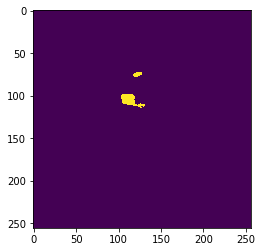

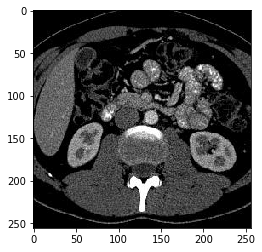

<Figure size 432x288 with 0 Axes>

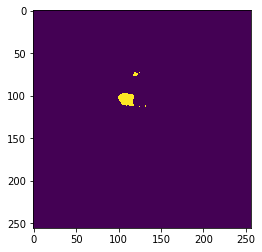

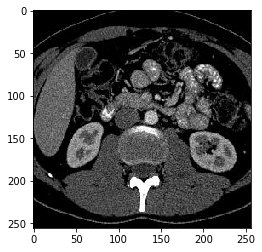

<Figure size 432x288 with 0 Axes>

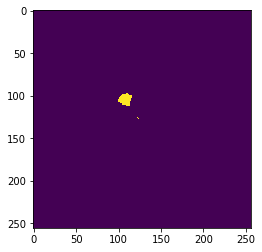

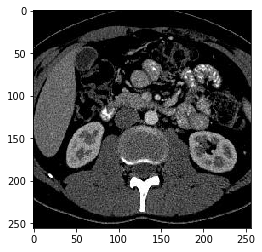

<Figure size 432x288 with 0 Axes>

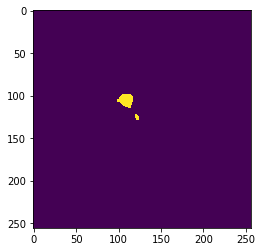

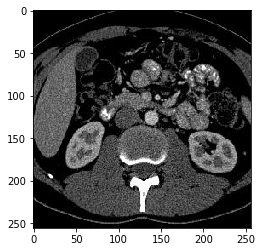

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
model.load_weights("./model.h5")
preds_test = model.predict(test_X, verbose=1)
preds_test = (preds_test > 0.5).astype(np.uint8)

for i in range(10):  # look at first 10 test images
  show = preds_test[i,...,0].astype('uint8')
  plt.figure()
  plt.imshow(show)
  plt.show()
  plt.clf()
  SHOW = test_X[i,...,0]
  plt.imshow(SHOW, cmap=plt.get_cmap('gray'))
  plt.show()
  plt.clf()

In [0]:
# reference on datagenerator:
# https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

################################################################################################################################################################################
## . Now prepare for data generator. With Keras, you must specifically prepare you data to be 'generated' if you want it to also do augmentation
# this is what we must do...
# convert from int to float
#X_train = train_X.astype('float32')
#X_test = test_X.astype('float32')
# define data preparation
# It is  possible to standardize pixel values across the entire dataset. This is called feature standardization and mirrors the type of standardization often performed for 
# each column in a tabular dataset. You can perform feature standardization by setting the featurewise_center and featurewise_std_normalization arguments on the 
# ImageDataGenerator class. These are in fact set to True by DEFAULT and creating an instance of ImageDataGenerator with no arguments will have the same effect.
# We don't want this since the CT data has a specific meaning that we will preserve. For MRI, this may desirable.
#datagen = ImageDataGenerator(featurewise_center=False, featurewise_std_normalization=False)
#datagen = ImageDataGenerator(rotation_range=90)
# A whitening transform of an image is a linear algebra operation that reduces the redundancy in the matrix of pixel images.
# Less redundancy in the image is intended to better highlight the structures and features in the image to the learning algorithm.
# Typically, image whitening is performed using the Principal Component Analysis (PCA) technique. More recently, an alternative called ZCA 
# shows better results and results in transformed images that keeps all of the original dimensions and unlike PCA, resulting transformed images still look like their originals.
#datagen = ImageDataGenerator(zca_whitening=True)
#datagen = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2)
#datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
from keras.preprocessing.image import ImageDataGenerator

mydatagen = ImageDataGenerator(featurewise_center=False, featurewise_std_normalization=False, rotation_range=20, zca_whitening=False, \
                               width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, vertical_flip=True)

# now point it to the data. One can point to memory ro disk
# memory version:
augmented_data_iterator = mydatagen.flow(train_X, train_Y)
# disk version:
# it = datagen.flow_from_directory(X, y, ...)

In [22]:


###########################################################################################################################
# fit parameters from data using datagenerator   Might save this for article 5????
steps_per_epoch = len(train_X) / epochs

#model.fit_generator(augmented_data_iterator, steps_per_epoch=313, ...)

history = model.fit_generator(generator=augmented_data_iterator,
                                  validation_data=(val_X, val_Y),
                                  # validation_data=None,
                                  steps_per_epoch=len(train_X),
                                  validation_steps=len(val_X),
                                  verbose=2,
                                  epochs=epochs,
                                  callbacks=[checkpointer],
                                  use_multiprocessing=True)

Epoch 1/10


ResourceExhaustedError: ignored